# PCA e Árvore de Decisão para Trading

**Etapas**<br>
<br>
• Passo 0  - Assistir aulas anteriores <br>
• Passo 1  - Carregar bibiotecas<br>
• Passo 2  - Carregar base de dados<br>
• Passo 3  - Tratamento de dados<br>
• Passo 4  - Contrução de alvos e variáveis<br>
• Passo 5  - Preparação da base para treinamento e teste e aplicando PCA<br>
• Passo 6  - Treinamento do modelo sem PCA<br>
• Passo 7  - Avaliação de resultados<br>
• Passo 8  - Treinamento do modelo com PCA<br>
• Passo 9  - Avaliação dos modelos<br>
• Passo 10 - Como usar o modelo na prática<br><br>

**What is PCA in data science?**<br><br>
**Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.**

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import os
os.chdir("C:\\Users\\dalto\\OpM na Prática\\Python\\Base de Dados")

df = pd.read_csv("EURUSD_Daily_Bid_2009.09.30_2019.10.24.csv", sep = ";")

df.shape

(2627, 6)

In [14]:
df = df.rename(columns={"Time (CAT)" : "Date"})

In [15]:
# Ajustando a data - precisamos transformá-la nos índices do data frame
df["Data"] = pd.to_datetime(df["Date"]).dt.normalize()
df = df.set_index("Data")
df.drop(["Date"], axis = 1, inplace = True)
df.head()

,Open,High,Low,Close,Volume
Data,,,,,
2009-09-30,1.46404,1.46668,1.45154,1.45415,80746.3
2009-10-01,1.45436,1.46467,1.44792,1.45743,80633.4
2009-10-04,1.45773,1.46685,1.45772,1.46480,81029.8
2009-10-05,1.46457,1.47612,1.46430,1.47212,81421.4
2009-10-06,1.47200,1.47361,1.46480,1.46887,81847.6


In [16]:
df.describe()

,Open,High,Low,Close,Volume
count,2627.000000,2627.000000,2627.000000,2627.000000,2.627000e+03
mean,1.239255,1.244429,1.234097,1.239194,2.251913e+05
std,0.118138,0.118662,0.117213,0.118073,1.554760e+05
min,1.038830,1.041780,1.034030,1.038820,0.000000e+00
25%,1.127320,1.131965,1.122620,1.127325,1.603489e+05
50%,1.237660,1.243490,1.232310,1.237660,2.045263e+05
75%,1.338700,1.343585,1.333580,1.338740,2.504352e+05
max,1.513320,1.514410,1.503900,1.513280,1.469805e+06


In [17]:
per = 1

df["Retorno"] = df["Close"].pct_change(per) #retorna a variação percentual da variável alvo em relação ao periodo anterior
df["Alvo1"] = df["Retorno"].shift(-per)  #Cria uma nova coluna deslocada negativamente em um período

# variação em Pips
df["Pips"] = (df["Close"] - df["Close"].shift(1))*10000 #Pega a variação de valor absoluto entre um e outro
df["Pips"] =  df["Pips"].shift(-per)

# Criação do alvo cateórico
df["AlvoBin"] = np.where(df['Alvo1'] > 0, 1, 0)

In [18]:
df.head()

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin
Data,,,,,,,,,
2009-09-30,1.46404,1.46668,1.45154,1.45415,80746.3,NaN,0.002256,32.8,1
2009-10-01,1.45436,1.46467,1.44792,1.45743,80633.4,0.002256,0.005057,73.7,1
2009-10-04,1.45773,1.46685,1.45772,1.46480,81029.8,0.005057,0.004997,73.2,1
2009-10-05,1.46457,1.47612,1.46430,1.47212,81421.4,0.004997,-0.002208,-32.5,0
2009-10-06,1.47200,1.47361,1.46480,1.46887,81847.6,-0.002208,0.007046,103.5,1


In [19]:
df.tail()

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin
Data,,,,,,,,,
2019-10-20,1.11607,1.11793,1.11386,1.11487,127017.5650,-0.001934,-0.002189,-24.4,0
2019-10-21,1.11487,1.11568,1.11176,1.11243,124844.3600,-0.002189,0.000485,5.4,1
2019-10-22,1.11242,1.11405,1.11061,1.11297,114032.9300,0.000485,-0.002336,-26.0,0
2019-10-23,1.11296,1.11627,1.10930,1.11037,147677.3094,-0.002336,-0.002224,-24.7,0
2019-10-24,1.11036,1.11229,1.10729,1.10790,104934.8200,-0.002224,NaN,NaN,0


In [21]:
df["AlvoBin"].value_counts(normalize=True)*100

0    50.171298
1    49.828702
Name: AlvoBin, dtype: float64

# Contrução de variáveis


In [25]:
# Construção das Variáveis

# Desvio Padrão de 5 dias
df["std5"] = df["Close"].rolling(5).std()

# Desvio Padrão de 10 dias
df["std10"] = df["Close"].rolling(10).std()

# Desvio Padrão de 15 dias
df["std15"] = df["Close"].rolling(15).std()

# Proporção do corpo do candle em relação ao range do dia
df["prop"] = (df["Close"]-df["Open"])/(df["High"]-df["Low"])

# Direção do dia atual
df["dirD"] = np.where(df["Close"] > df["Open"], '1', '0')

# Direção D-1
df["dirD-1"] = df["dirD"].shift(1)

# Direção D-2
df["dirD-2"] = df["dirD"].shift(2)

# Direção D-3
df["dirD-3"] = df["dirD"].shift(3)


# Média móvel de 15 dias
df["MM"] = df["Close"].rolling(15).mean()

# Zscore
df["zscore"] = (df["Close"]-df["MM"])/df["std15"]

# RSL
df["RSL"] = (df["Close"]/df["MM"])-1

In [27]:
df.tail()

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2019-10-20,1.11607,1.11793,1.11386,1.11487,127017.5650,-0.001934,-0.002189,-24.4,0,0.005682,0.007324,0.007499,-0.294840,0,1,1,1,1.102228,1.685735,0.011469
2019-10-21,1.11487,1.11568,1.11176,1.11243,124844.3600,-0.002189,0.000485,5.4,1,0.003708,0.006745,0.007481,-0.622449,0,0,1,1,1.103516,1.191615,0.008078
2019-10-22,1.11242,1.11405,1.11061,1.11297,114032.9300,0.000485,-0.002336,-26.0,0,0.002012,0.005970,0.007537,0.159884,1,0,0,1,1.104654,1.103293,0.007528
2019-10-23,1.11296,1.11627,1.10930,1.11037,147677.3094,-0.002336,-0.002224,-24.7,0,0.002528,0.005251,0.007292,-0.371593,0,1,0,0,1.105594,0.654928,0.004320
2019-10-24,1.11036,1.11229,1.10729,1.10790,104934.8200,-0.002224,NaN,NaN,0,0.002665,0.004819,0.006963,-0.492000,0,0,1,0,1.106281,0.232548,0.001464


In [28]:
dff = df.dropna(axis = 0)

In [29]:
dff.head()

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2009-10-20,1.49449,1.50456,1.48846,1.50151,79788.7,0.004731,0.001059,15.9,1,0.004043,0.009404,0.014883,0.436025,1,0,1,0,1.480112,1.437722,0.014457
2009-10-21,1.50146,1.50383,1.49413,1.50310,80394.2,0.001059,-0.001683,-25.3,0,0.005222,0.009827,0.014132,0.169072,1,1,0,1,1.483375,1.395780,0.013297
2009-10-22,1.50298,1.50590,1.49830,1.50057,79298.1,-0.001683,-0.008757,-131.4,0,0.003653,0.007935,0.012801,-0.317105,0,1,1,0,1.486251,1.118521,0.009634
2009-10-25,1.49934,1.50600,1.48420,1.48743,79935.1,-0.008757,-0.004841,-72.0,0,0.006473,0.005979,0.011343,-0.546330,0,0,1,1,1.487760,-0.029092,-0.000222
2009-10-26,1.48750,1.49260,1.47660,1.48023,79202.0,-0.004841,-0.006648,-98.4,0,0.010168,0.006963,0.010721,-0.454375,0,0,0,1,1.488301,-0.752811,-0.005423


In [30]:
pd.qcut(dff["zscore"],5) # Divide o DataFrame em 5 partes tomando como base o Zscore

Data
2009-10-20        (1.2, 3.056]
2009-10-21        (1.2, 3.056]
2009-10-22         (0.38, 1.2]
2009-10-25      (-0.574, 0.38]
2009-10-26    (-1.309, -0.574]
                    ...       
2019-10-17        (1.2, 3.056]
2019-10-20        (1.2, 3.056]
2019-10-21         (0.38, 1.2]
2019-10-22         (0.38, 1.2]
2019-10-23         (0.38, 1.2]
Name: zscore, Length: 2609, dtype: category
Categories (5, interval[float64]): [(-3.032, -1.309] < (-1.309, -0.574] < (-0.574, 0.38] < (0.38, 1.2] < (1.2, 3.056]]

In [31]:
pd.qcut(dff["zscore"],5 , labels = False) # Ao invés de mostrar em que divisão ele está, o método dá um número a ele

Data
2009-10-20    4
2009-10-21    4
2009-10-22    3
2009-10-25    2
2009-10-26    1
             ..
2019-10-17    4
2019-10-20    4
2019-10-21    3
2019-10-22    3
2019-10-23    3
Name: zscore, Length: 2609, dtype: int64

In [32]:
# Associando as divisões do Zscore ao alvo
pd.crosstab(pd.qcut(dff["zscore"], 10, labels = False), dff["AlvoBin"])/df.shape[0]*100

AlvoBin,0,1
zscore,,
0,4.720213,5.215074
1,4.758279,5.177008
2,5.177008,4.758279
3,4.453750,5.481538
4,5.177008,4.758279
5,4.720213,5.177008
6,5.062809,4.872478
7,5.329273,4.606014
8,4.720213,5.215074


In [33]:
# Associando as divisões do RSL ao alvo
pd.crosstab(pd.qcut(dff["RSL"], 10, labels = False), dff["AlvoBin"])/df.shape[0]*100

AlvoBin,0,1
RSL,,
0,4.720213,5.215074
1,4.720213,5.215074
2,5.215074,4.720213
3,4.720213,5.215074
4,4.834412,5.100876
5,4.606014,5.291207
6,5.443472,4.491816
7,5.138942,4.796346
8,4.910544,5.024743


In [34]:
dff["RSL"] = pd.qcut(dff["RSL"], 10, labels = False)

<ipython-input-34-bf0006fd88ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["RSL"] = pd.qcut(dff["RSL"], 10, labels = False)


In [35]:
dff["zscore"] = pd.qcut(dff["zscore"], 10, labels = False)

<ipython-input-35-dd94e6ce43e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["zscore"] = pd.qcut(dff["zscore"], 10, labels = False)


In [37]:
dff.head()

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2009-10-20,1.49449,1.50456,1.48846,1.50151,79788.7,0.004731,0.001059,15.9,1,0.004043,0.009404,0.014883,0.436025,1,0,1,0,1.480112,8,9
2009-10-21,1.50146,1.50383,1.49413,1.50310,80394.2,0.001059,-0.001683,-25.3,0,0.005222,0.009827,0.014132,0.169072,1,1,0,1,1.483375,8,9
2009-10-22,1.50298,1.50590,1.49830,1.50057,79298.1,-0.001683,-0.008757,-131.4,0,0.003653,0.007935,0.012801,-0.317105,0,1,1,0,1.486251,7,8
2009-10-25,1.49934,1.50600,1.48420,1.48743,79935.1,-0.008757,-0.004841,-72.0,0,0.006473,0.005979,0.011343,-0.546330,0,0,1,1,1.487760,5,5
2009-10-26,1.48750,1.49260,1.47660,1.48023,79202.0,-0.004841,-0.006648,-98.4,0,0.010168,0.006963,0.010721,-0.454375,0,0,0,1,1.488301,3,3


In [38]:
sTrain = "2009-09-30"
eTrain = "2013-12-31"
# Teste de 2014 a 2019
sTest = "2014-01-01"
eTest = "2019-10-24"

dfTrain = dff[sTrain : eTrain]
dfTest = dff[sTest : eTest]

In [39]:
print(dfTrain.shape)
print(dfTest.shape)

(1095, 20)
(1514, 20)


In [41]:
xTrain = dfTrain.iloc[:,9:df.shape[1]]
yTrain = dfTrain["AlvoBin"]

xTest = dfTest.iloc[:,9:df.shape[1]]
yTest = dfTest["AlvoBin"]

**Atenção aos métodos a seguir: fit_transform e transform** <br>
<br>
Esses métodos são usados para centralizar/redimensionar os dados fornecidos<br>
<br>
•Fit(): calcula os parâmetros µ e σ e os salva como objetos;<br>
•Transform(): usa os parâmetros calculados em fit() e aplica a transformação a um conjunto de dados específico;<br>
•Fit_transform(): associa o método fit() e transform() para transformação do conjunto de dados.<br>

In [42]:
# Padronizando a base

sc = StandardScaler()

xTrainPCA = sc.fit_transform(xTrain) 
xTestPCA = sc.transform(xTest)  # Ao não usar o fit() no teste, o StandardScaler usa as variáveis obtidas no treinamento

In [43]:
pca = PCA(n_components = 10)

pcas = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"]

xTrainPCA = pca.fit_transform(xTrainPCA) 
xTestPCA = pca.transform(xTestPCA)

In [44]:
xTrainPCA[1]

array([-1.55077106,  1.05677169,  0.66122974, -1.54488907,  0.05803428,
        2.27867727,  0.65826425, -0.43252814,  0.12421894,  0.5037488 ])

In [45]:
# Entendedo o que temos dentro da PCA

vars(pca)

{'n_components': 10,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'random_state': None,
 'n_features_in_': 11,
 '_fit_svd_solver': 'full',
 'mean_': array([-5.19117980e-17, -2.59558990e-16, -2.07647192e-16,  1.13557058e-17,
         5.51562854e-17,  4.86673107e-17,  6.16452602e-17, -5.51562854e-17,
        -3.63382586e-16, -2.27114116e-17, -2.59558990e-17]),
 'noise_variance_': 0.03452250267992835,
 'n_samples_': 1095,
 'n_features_': 11,
 'components_': array([[ 0.27054873,  0.29997458,  0.27868465, -0.34319823, -0.31993905,
         -0.13731595, -0.12964246, -0.12485762,  0.12086996, -0.49247606,
         -0.48022183],
        [ 0.39991246,  0.51218477,  0.47022422,  0.3797141 ,  0.38098744,
         -0.01360259, -0.0110407 ,  0.01522029,  0.12069139,  0.17548149,
          0.14626341],
        [ 0.13146966,  0.180956  ,  0.18220922, -0.42860448, -0.45006606,
          0.41941443,  0.29085138,  0.24998394,  0.04847164,  0.30591036,


In [46]:
expVar = pca.explained_variance_ratio_

sum(expVar)

0.9968644567927071

# Passo 7 - Treinamento do Modelo sem PCA

**Atente-se aos parâmetros de otimização da árvore de decisão**

•max_depth: profundidade máxima da árvore; <br>
•min_samples_leaf: número mínimo de registros por "folha";<br>
•min_samples_split: número mínimo de registros por quebra de cada nó;<br>
•max_leaf_nodes: numero máximo de folhas(finais, aquelas que não se separam mais) na ávore.<br>

In [49]:
from sklearn.tree import DecisionTreeClassifier

modTree = DecisionTreeClassifier(criterion = "gini", 
                                max_depth = 10,
                                min_samples_leaf = 50,
                                min_samples_split = 5,
                                max_leaf_nodes = 10)

modTree.fit(xTrain,yTrain)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=50,
                       min_samples_split=5)

In [52]:
predTest = modTree.predict(xTest)

In [61]:
print(confusion_matrix(yTest, predTest))
print()
print("------------------------------------------------")
print()
print(classification_report(yTest,predTest))

print("Acurácia: ", round(metrics.accuracy_score(yTest, predTest)*100,3))

[[113 663]
 [ 84 654]]

------------------------------------------------

              precision    recall  f1-score   support

           0       0.57      0.15      0.23       776
           1       0.50      0.89      0.64       738

    accuracy                           0.51      1514
   macro avg       0.54      0.52      0.43      1514
weighted avg       0.54      0.51      0.43      1514

Acurácia:  50.661


In [64]:
dfTest.loc[:,"PrevistoSemPCA"] = predTest

In [72]:
dfTest["PrevistoSemPCA"].astype(str)

Data
2014-01-02    0
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    1
             ..
2019-10-17    1
2019-10-20    1
2019-10-21    1
2019-10-22    1
2019-10-23    1
Name: PrevistoSemPCA, Length: 1514, dtype: object

In [82]:
dfTest.loc[:, "RetPipsSemPCA"] = np.where(dfTest.loc[:,"PrevistoSemPCA"] == 1, dfTest.loc[:,'Pips'], '0')
dfTest.loc[:, "RetPipsSemPCA"] = np.where(dfTest.loc[:,"PrevistoSemPCA"] == 0, -1*dfTest.loc[:,'Pips'], dfTest.loc[:,"RetPipsSemPCA"])

C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [83]:
dfTest.loc[:, "RetPipsSemPCA"] =  dfTest["RetPipsSemPCA"].astype(float)

In [84]:
dfTest.loc[:, "RetPipsAcumuladoSemPCA"] = dfTest["RetPipsSemPCA"].cumsum()

In [85]:
dfTest.loc[:,"RetPipsAcumuladoSemPCA"].tail()

Data
2019-10-17    942.3
2019-10-20    917.9
2019-10-21    923.3
2019-10-22    897.3
2019-10-23    872.6
Name: RetPipsAcumuladoSemPCA, dtype: float64

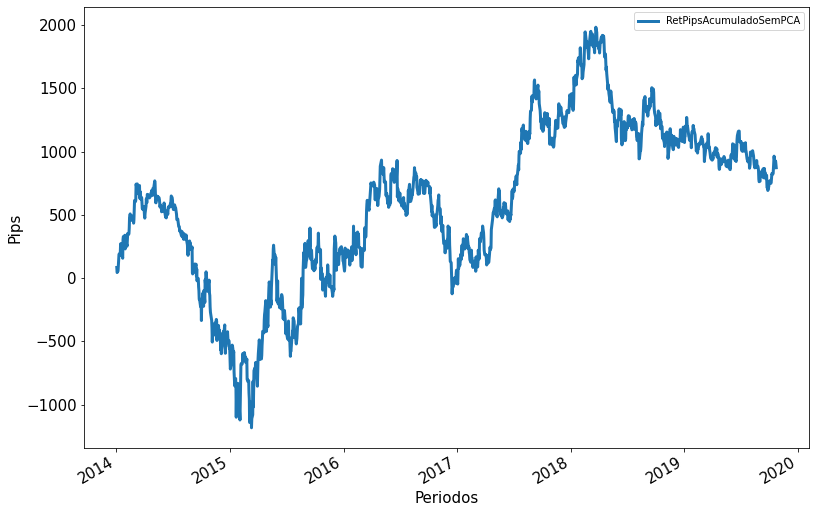

In [86]:
dfTest["RetPipsAcumuladoSemPCA"].plot(figsize = (13,9)
                              ,linewidth = 3
                              ,fontsize = 15)
plt.xlabel('Periodos'
          , fontsize = 15)
plt.ylabel('Pips'
          , fontsize = 15)
plt.legend();

In [87]:
from sklearn.tree import DecisionTreeClassifier

modTreePCA = DecisionTreeClassifier(criterion = "gini", 
                                max_depth = 10,
                                min_samples_leaf = 50,
                                min_samples_split = 5,
                                max_leaf_nodes = 10)

modTreePCA.fit(xTrainPCA,yTrain)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=50,
                       min_samples_split=5)

In [88]:
predTestPCA = modTreePCA.predict(xTestPCA)

In [89]:
print(confusion_matrix(yTest, predTestPCA))
print()
print("------------------------------------------------")
print()
print(classification_report(yTest,predTestPCA))

print("Acurácia: ", round(metrics.accuracy_score(yTest, predTestPCA)*100,3))

[[378 398]
 [317 421]]

------------------------------------------------

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       776
           1       0.51      0.57      0.54       738

    accuracy                           0.53      1514
   macro avg       0.53      0.53      0.53      1514
weighted avg       0.53      0.53      0.53      1514

Acurácia:  52.774


In [90]:
dfTest.loc[:,"PrevistoComPCA"] = predTestPCA

C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [91]:
dfTest["PrevistoComPCA"].astype(str)

Data
2014-01-02    0
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    1
             ..
2019-10-17    0
2019-10-20    0
2019-10-21    1
2019-10-22    1
2019-10-23    1
Name: PrevistoComPCA, Length: 1514, dtype: object

In [92]:
dfTest.loc[:, "RetPipsComPCA"] = np.where(dfTest.loc[:,"PrevistoComPCA"] == 1, dfTest.loc[:,'Pips'], '0')
dfTest.loc[:, "RetPipsComPCA"] = np.where(dfTest.loc[:,"PrevistoComPCA"] == 0, -1*dfTest.loc[:,'Pips'], dfTest.loc[:,"RetPipsComPCA"])

C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [93]:
dfTest.loc[:, "RetPipsComPCA"] =  dfTest["RetPipsComPCA"].astype(float)

In [94]:
dfTest.loc[:, "RetPipsAcumuladoComPCA"] = dfTest["RetPipsComPCA"].cumsum()

C:\Users\dalto\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [95]:
dfTest.loc[:,"RetPipsAcumuladoComPCA"].tail()

Data
2019-10-17    6240.5
2019-10-20    6264.9
2019-10-21    6270.3
2019-10-22    6244.3
2019-10-23    6219.6
Name: RetPipsAcumuladoComPCA, dtype: float64

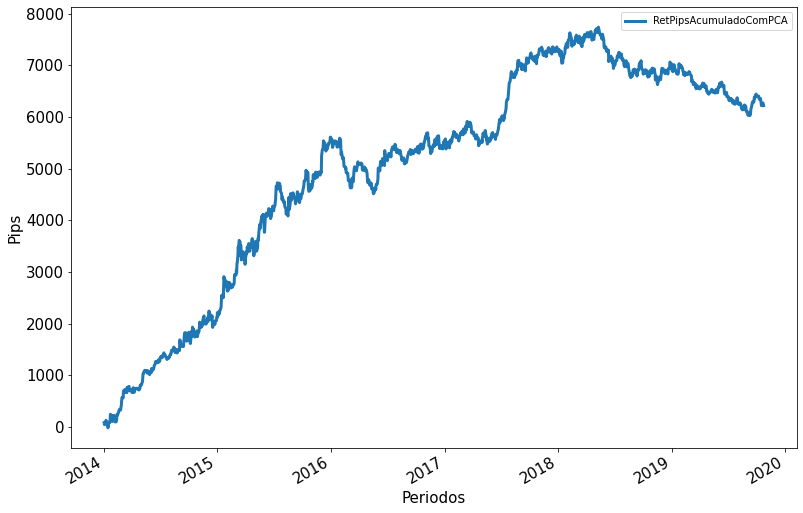

In [96]:
dfTest["RetPipsAcumuladoComPCA"].plot(figsize = (13,9)
                              ,linewidth = 3
                              ,fontsize = 15)
plt.xlabel('Periodos'
          , fontsize = 15)
plt.ylabel('Pips'
          , fontsize = 15)
plt.legend();

# Passo 11 - Como usar o modelo na prática

In [97]:
df.tail(3)

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2019-10-22,1.11242,1.11405,1.11061,1.11297,114032.9300,0.000485,-0.002336,-26.0,0,0.002012,0.005970,0.007537,0.159884,1,0,0,1,1.104654,1.103293,0.007528
2019-10-23,1.11296,1.11627,1.10930,1.11037,147677.3094,-0.002336,-0.002224,-24.7,0,0.002528,0.005251,0.007292,-0.371593,0,1,0,0,1.105594,0.654928,0.004320
2019-10-24,1.11036,1.11229,1.10729,1.10790,104934.8200,-0.002224,NaN,NaN,0,0.002665,0.004819,0.006963,-0.492000,0,0,1,0,1.106281,0.232548,0.001464


In [138]:
# Primeiro, crie uma nova linha de valores do dia

hoje = pd.Series( data = {"Open": 1.119, "High" : 1.1200, "Low" : 1.155, "Close" : 1.16}, name = "2019-10-29 00:00:00")

df = df.append(hoje, ignore_index = False)

df.tail(3)

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2019-10-27 00:00:00,1.110,1.125,1.105,1.123,NaN,0.015371,0.059662,670.0,1.0,0.006720,0.004869,0.006131,0.650000,1,0,0,0,1.109532,2.196545,0.012138
2019-10-28 00:00:00,1.123,1.128,1.185,1.190,NaN,0.059662,NaN,NaN,0.0,0.035695,0.024932,0.021357,-1.175439,1,1,0,0,1.115499,3.488344,0.066787
2019-10-29 00:00:00,1.119,1.120,1.155,1.160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:

df["Retorno"] = df["Close"].pct_change(per) #retorna a variação percentual da variável alvo em relação ao periodo anterior
df["Alvo1"] = df["Retorno"].shift(-per)  #Cria uma nova coluna deslocada negativamente em um período

# variação em Pips
df["Pips"] = (df["Close"] - df["Close"].shift(1))*10000 #Pega a variação de valor absoluto entre um e outro
df["Pips"] =  df["Pips"].shift(-per)

# Criação do alvo cateórico
df["AlvoBin"] = np.where(df['Alvo1'] > 0, 1, 0)

# Desvio Padrão de 5 dias
df["std5"] = df["Close"].rolling(5).std()

# Desvio Padrão de 10 dias
df["std10"] = df["Close"].rolling(10).std()

# Desvio Padrão de 15 dias
df["std15"] = df["Close"].rolling(15).std()

# Proporção do corpo do candle em relação ao range do dia
df["prop"] = (df["Close"]-df["Open"])/(df["High"]-df["Low"])

# Direção do dia atual
df["dirD"] = np.where(df["Close"] > df["Open"], '1', '0')

# Direção D-1
df["dirD-1"] = df["dirD"].shift(1)

# Direção D-2
df["dirD-2"] = df["dirD"].shift(2)

# Direção D-3
df["dirD-3"] = df["dirD"].shift(3)


# Média móvel de 15 dias
df["MM"] = df["Close"].rolling(15).mean()

# Zscore
df["zscore"] = (df["Close"]-df["MM"])/df["std15"]

# RSL
df["RSL"] = (df["Close"]/df["MM"])-1

dff = df.dropna(axis = 0)

dff["RSL"] = pd.qcut(dff["RSL"], 10, labels = False)

dff["zscore"] = pd.qcut(dff["zscore"], 10, labels = False)

dffPCA = sc.transform(dff.iloc[:, 9:df.shape[1]])


<ipython-input-139-0b23a27d2eeb>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["RSL"] = pd.qcut(dff["RSL"], 10, labels = False)
<ipython-input-139-0b23a27d2eeb>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["zscore"] = pd.qcut(dff["zscore"], 10, labels = False)


In [140]:
dffPCA

array([[-0.83637325, -0.16668995,  0.45183646, ...,  2.18150285,
         1.10624837,  1.37870972],
       [-0.53635019, -0.07622703,  0.31476864, ...,  2.23258371,
         1.10624837,  1.37870972],
       [-0.93557532, -0.4804671 ,  0.07218885, ...,  2.27760166,
         0.76760091,  1.06445344],
       ...,
       [-1.35294684, -0.90002163, -0.8877609 , ..., -3.69553092,
         0.76760091,  0.75019717],
       [-1.22181184, -1.05362409, -0.93244512, ..., -3.68081713,
         0.42895345,  0.43594089],
       [-1.18692512, -1.14582022, -0.99243905, ..., -3.67006875,
         0.09030599,  0.12168462]])

In [117]:
#dffPCA = dffPCA.reshape(-1,1)

In [141]:
dffPCA = pca.transform(dffPCA)


In [142]:
df.tail(3)

,Open,High,Low,Close,Volume,Retorno,Alvo1,Pips,AlvoBin,std5,std10,std15,prop,dirD,dirD-1,dirD-2,dirD-3,MM,zscore,RSL
Data,,,,,,,,,,,,,,,,,,,,
2019-10-27 00:00:00,1.110,1.125,1.105,1.123,NaN,0.015371,0.059662,670.0,1,0.006720,0.004869,0.006131,0.650000,1,0,0,0,1.109532,2.196545,0.012138
2019-10-28 00:00:00,1.123,1.128,1.185,1.190,NaN,0.059662,-0.025210,-300.0,0,0.035695,0.024932,0.021357,-1.175439,1,1,0,0,1.115499,3.488344,0.066787
2019-10-29 00:00:00,1.119,1.120,1.155,1.160,NaN,-0.025210,NaN,NaN,0,0.036224,0.027821,0.023909,-1.171429,1,1,1,0,1.119279,1.703175,0.036381


In [143]:
modTreePCA.predict(dffPCA)[-1]

1